<a href="https://colab.research.google.com/github/SeanRommes/Project-2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Heart Failure Prediction (Project 2)

Sean Rommes

# Heart Failure Prediction Dataset
11 clinical features for predicting heart disease events.


##Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Description

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

## The Data

This DataSet is a classification problem which has 918 rows, 12 columns, and 11 features. My target will be if a person has heart disease or not. I see 5 categorical features which I will have to onehot encode. I'll check for any missing values, duplicated rows, and ensure all the columns are consistent with their types. Before I begin my ML models i'll check which features have the highest correlations to my target using a heat map, anything below .3 I'll drop before instantiating the train test split. The data is a little but small and biased towards middle aged individuals

In [307]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from sklearn import set_config
set_config(display='diagram')

In [308]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo Course Work/Week 7: Logistic Regression and Regularization/True Heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [309]:
#getting number of rows and columns

df.shape

(918, 12)

# Cleaning the data

In [310]:
#getting an overview of types, searching for inconsistencies

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [311]:
# getting statistical values to search for unusual data points

df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


I see some unusual values, resting bp with a min value at 0 stands out to me, i'll check all the 0 min values just to be sure.

In [312]:
#checking missing values

df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [313]:
#checking number of unique values

df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [314]:
# checking for duplicates

df.duplicated().sum()

0

In [315]:
# checking how much people had heart disease
# The data set is fairly well split with 56% of people having heart disease and 44% without.
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [316]:
#checking for odd values in age

df['Age'].value_counts()

54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: Age, dtype: int64

In [317]:
df['Sex'].value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [318]:
#checking resting bp for abnormalities

df['RestingBP'].value_counts()

120    132
130    118
140    107
110     58
150     55
      ... 
185      1
98       1
92       1
113      1
164      1
Name: RestingBP, Length: 67, dtype: int64

In [319]:
# looking into 0 value for bp as mentioned earlier, one result.

RBP = df['RestingBP'] == 0
RBP.sum()

1

In [320]:
# checking cholesterol. I find it odd that 172 people had a cholesterol level of 0.
# 0 cholesterol isnt impossible but I do find it unlikely for so many people.

df['Cholesterol'].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: Cholesterol, Length: 222, dtype: int64

In [321]:
# checking values, TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic

df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [322]:
# checking fasting blood sugar column, looks like true or false values, does this mean that blood sugar levels were tested during fasting? or is this an error?
# data index reveals that this column is checking if fasting blood sugar is > 120 mg/dl  (1 = true; 0 = false)

df['FastingBS'].value_counts()

0    704
1    214
Name: FastingBS, dtype: int64

In [323]:
# lvh is defined as left ventriclular hypertrophy and st as strain

df['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [324]:
# I didnt see any unusual values in max heart rate, but checking anyway.

df['MaxHR'].value_counts()

150    43
140    41
120    36
130    33
160    25
       ..
63      1
83      1
60      1
78      1
202     1
Name: MaxHR, Length: 119, dtype: int64

Max heartrate is measured using 220 minus your age. The lowest age in the dataset is 28 wich would mean 220 - 28 would put the highest max hr at 192. the highest age is 77, which would put the lowest max hr at 143. 202 or age 28 is a mistake as a max hr of 202 would put a person at the age of 18, which isnt present in this dataset. I'm going to keep the ages the same and consider changing all the invalid max hr outliers in this dataset to correspond to their appropriate values. However there maybe other factors in those people im not aware of that could make those outliers valid.

There are definitly some outliers in this column, particularly around the low end. I cant consider anything above 120 an outlier as there are multiple values, but all these single ones are definintly my outliers and i'm not sure if those are accurate or not based off my research alone, or if there are other medical factors involved with those people.

In [325]:
#oldpeak defined as ST(strain) depression induced by exercise relative to rest, i'm not sure how to interpret the negative values and will leave those alone,there's alot of 0's here as well, they might be missing values in disguise
# or just no reaction. i'll leave those the same for now.

df['Oldpeak'].value_counts()

 0.0    368
 1.0     86
 2.0     76
 1.5     53
 3.0     28
 1.2     26
 0.2     22
 0.5     19
 1.4     18
 1.8     17
 2.5     16
 0.8     16
 1.6     16
 0.1     14
 0.6     14
 0.4     11
 0.3     11
 4.0      8
 0.7      7
 2.8      7
 1.9      7
 1.3      7
 2.6      7
 1.1      7
 1.7      6
 2.2      5
 0.9      4
 2.4      4
 3.6      4
 3.4      3
 4.2      2
 3.5      2
-0.5      2
 2.3      2
 3.2      2
 2.1      2
-1.0      2
-0.1      2
 5.6      1
 2.9      1
 6.2      1
 3.8      1
-1.5      1
 3.1      1
-2.0      1
 3.7      1
-0.8      1
-0.7      1
-1.1      1
-2.6      1
-0.9      1
 5.0      1
 4.4      1
Name: Oldpeak, dtype: int64

In [326]:
# checking for unusual values in strain slope

df['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

#Visualizations

##Outliers

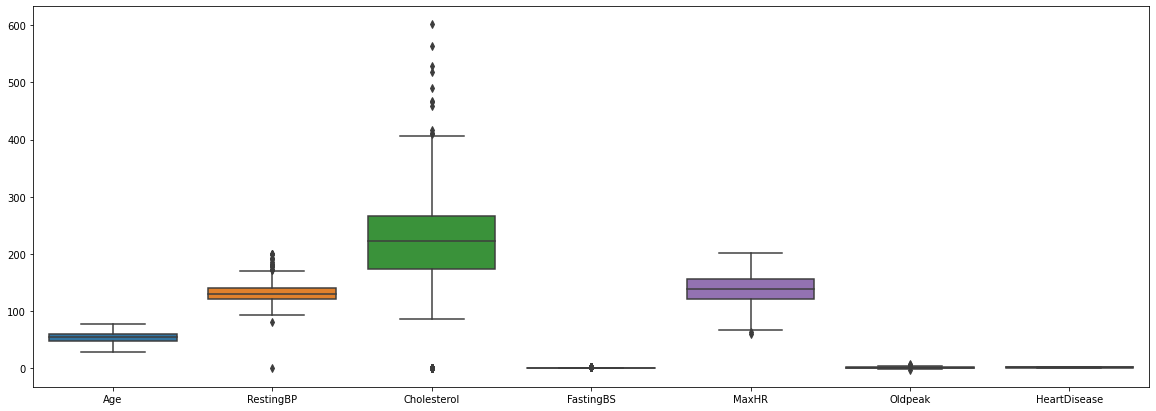

In [327]:
#Getting an overview of my outliers

plt.figure(figsize=(20,7))
sns.boxplot(data= df);


Most people in the data set are in their 50's with outliers ranging between 28 and 77. There's not alot of outliers below 100 for resting blood pressure, most lie above 200. Majority of the outliers have less than 200 cholesterol in the data set. 105 people in the data set had a cholesterol above 300 while 322 people had levels lower than 200 as portayed by the below code. This would place the remaining 491 individuals within the mean range. As mentioned before fasting bp in the dataset is just 1 or 0, was it above 120 mg/dl or not.

Max heart rate averaged around 136. The younger individuals would conisist of the outliers above 175. The below groupby has some interesting insights, most notabely being a 51 year old with a max hr of 60, sadly they had heart disease. The values for oldpeak are incredibly small and range from -2.6 to 6 most had an old peak of 0 or just slighty above 0. Heart disease in this graph is just 1 or 0 did they have it or not, so no outliers there. 

The other columns that are not present here are categorical columns and therfore wont have any numerical outliers to examine.

In [328]:
# comparing my outliers in cholesetrol for explanatory purposes

cholA = df['Cholesterol'] >= 300
cholB = df['Cholesterol'] <=200
print(cholA.sum())
print(cholB.sum())

105
322


In [329]:
#grouping age and whether or not they had heart disease by max hr to supoort my outliers boxplot

df.groupby(['MaxHR'])[['Age','HeartDisease','Cholesterol','Oldpeak']].quantile()

,Age,HeartDisease,Cholesterol,Oldpeak
MaxHR,,,,
60,51.0,1.0,0.0,0.0
63,60.0,1.0,0.0,0.5
67,65.0,1.0,0.0,0.7
69,58.0,0.0,458.0,1.0
70,61.0,1.0,0.0,0.0
...,...,...,...,...
190,43.0,0.0,173.5,0.0
192,34.0,0.0,210.0,0.7
194,42.0,0.0,240.0,0.8


Expanding on the heat map (way)below showing the correlate factors, you can see here that a person can have 0 cholesterol( or at least it wasnt tested) and still be unhealthy and have heart diease (Actually you can still be healthy and get heart disease, but its alot less likely). I cant help but wonder what else was going on with the first person on this groupby.

In [330]:
# I used this to help me get my values for the analysis of my boxplot

df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


##Univariate visualizations

TO DO: label table

define x and y

remove 0's

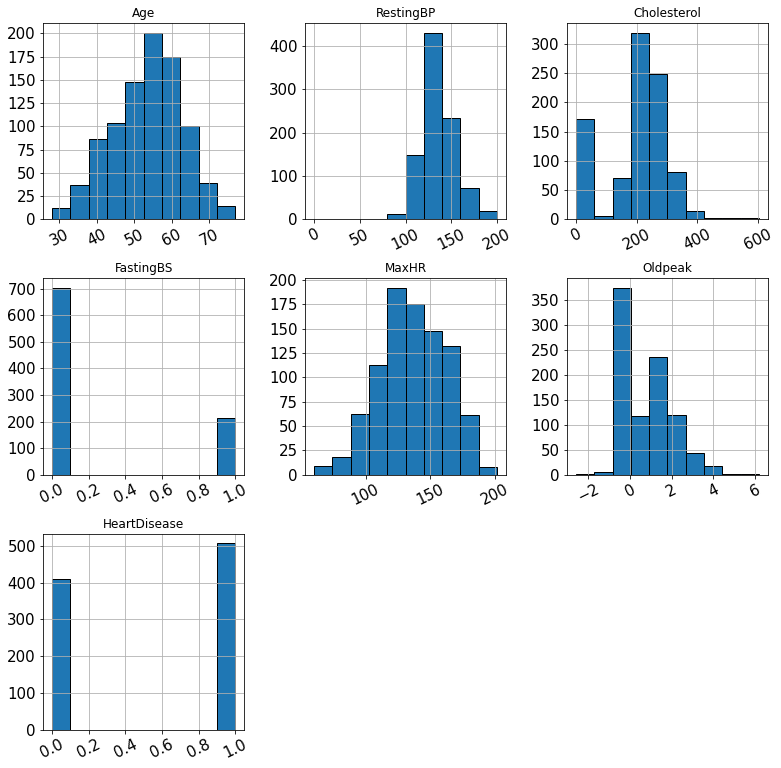

In [331]:
# creating a series of histograms theat present the numerical data
df.hist(edgecolor='black', 
        xlabelsize=15,
        ylabelsize=15,
        grid=True,
        figsize=[13,13],
        xrot=26,);


Most people in the dataset are in their mid 50's and early 60's. This is a common age for at risk individuals to develop heart disease.

Resting blood pressure was fairly common around 120 - 150, indicating high numbers of people experienceing elevated blood pressure.

According to the above histogram, most people had cholesterol between 200 and 300, the normal range for this is between 0 and 200, though I believe the having a cholesterol of 0 is quite anomalous and unlikely for so many people. It could be an indicator of heart disease or it could be an error in the dataset.

The fasting blood sugar table shows that over 700 people had fasting bloodsugar that was less than 120 mg, indicating a normal range. Anywhere between 0 and 99mg is considered normal, while ranges between 100 and 125 is considered prediabetic and anything above 125 indicates diabetes.

Max heart rate peaks around 120 and gets lower with age, as expected. I've explored this with some detail already and will continue exploring this in later visualizations.

Oldpeak has the highest number of patients with a score 0. With ranges between 1 and 4 becomeing more common with some outliers above 4 and below 0.  

Heart disease shows that just 400 people in the data set did not have heart disease whereas the other 500 people did.

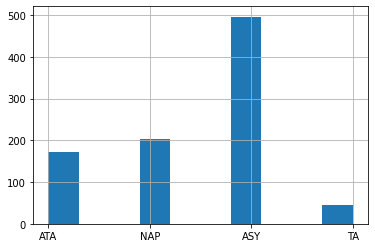

In [332]:
#Asymptomatic chestpain was the most common, meaning there was often no notcible symptoms present in most people.

df['ChestPainType'].hist(label= 'count');


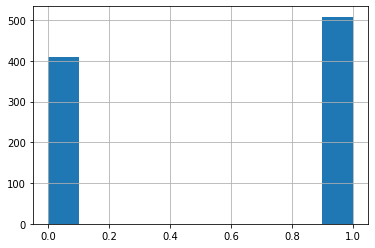

In [333]:
# this shows how many people did or did not have heart disease

df['HeartDisease'].hist();

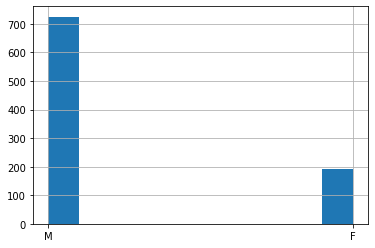

In [334]:
#this shows that most people in the sample were male

df['Sex'].hist();

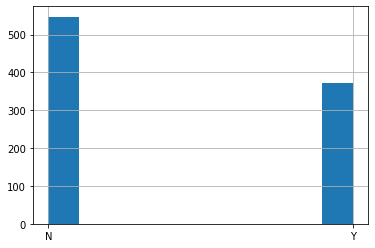

In [335]:
# angina during exercise is less common

df['ExerciseAngina'].hist();

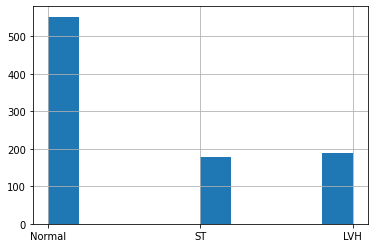

In [336]:
#most people had normal resting ecgs

df['RestingECG'].hist();

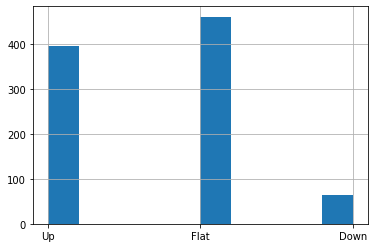

In [337]:
#majority of peoples st_slope were up or flat, meaning higher levels of depression after exercise or no change.
df['ST_Slope'].hist();

##Multivariate analysis

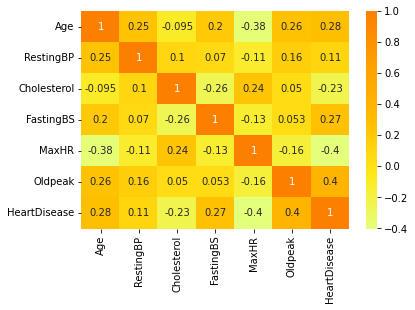

In [338]:
# I wanted to create a heatmap to view correlate factors

corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot = True);

This sample seems pretty well balanced, the heatmap above has surprisingly few strong correlates. Oldpeak seems to be the strongest factor, followed by age and fasting blood sugar. Our findings above support that cholesterols is not the best indicator of heart disease with one of the lowest correlational values. Sex isnt measured here but ordinarily males are at a higher risk of heart disease according to https://gh.bmj.com/content/2/2/e000298. The dataset seems to support this conclusion as well with 725(78%) of the 918 individuals in the data set identifying as male.

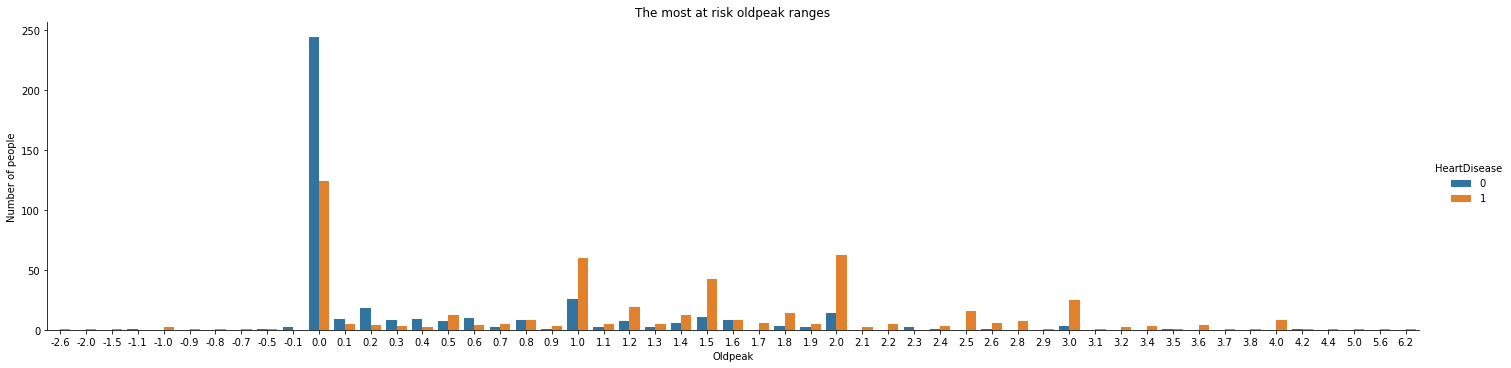

In [339]:
    g = sns.catplot(x= 'Oldpeak', data=df, aspect=4.0, kind = 'count',
                       hue='HeartDisease');
    g.set_ylabels('Number of people');
    plt.title('The most at risk oldpeak ranges');

Oldpeak had the highest correlation to heartdisease in the data set. This plot illustrates the oldpeak range with the highest distribution to heart disease. 0 oldpeak is the most common, while it had the largest ammounts of people testing positive for heart disease, it also had the largest amounts of people not having heart disease so you're significantly more likely not to have heart disease with 0 oldpeak than to test positive for it. Additionally that number has everything to do with the data set, with a larger and more diverse sample size, I'de be more comfortable with those values. The most at risk oldpeak rates, from highest to lowest, are 0.0, 1.0, 1.5, 2.0, 2.5, 3.0 and 4.0. While I dont like these consistintly shaped groupings (its too evenly spaced) thats what the data shows. Proportionatly those are the values that had more people testing positive for heartdisease than not. aside from 0, Any oldpeak range above 1.0 presents the highest distribution of heart disease with the vast mojority of people in this range developing heart disease.The higher the oldpeak the more likely you are to develop heart disease. 

In [340]:
#grouping mean age for visualzation
dfgroup = df.groupby(['Age']).mean()
dfgroup.head()

,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,,,,,,
28,130.0,132.000000,0.0,185.000000,0.00,0.0
29,130.0,236.666667,0.0,177.333333,0.00,0.0
30,170.0,237.000000,0.0,170.000000,0.00,0.0
31,110.0,244.500000,0.0,151.500000,0.75,0.5
32,110.6,241.200000,0.2,152.200000,0.14,0.4


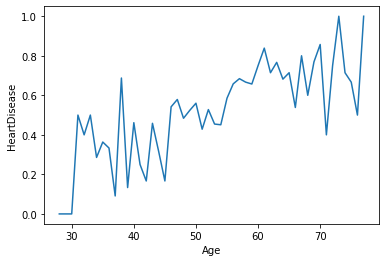

In [341]:
sns.lineplot(x= dfgroup.index, y = 'HeartDisease', data = dfgroup);

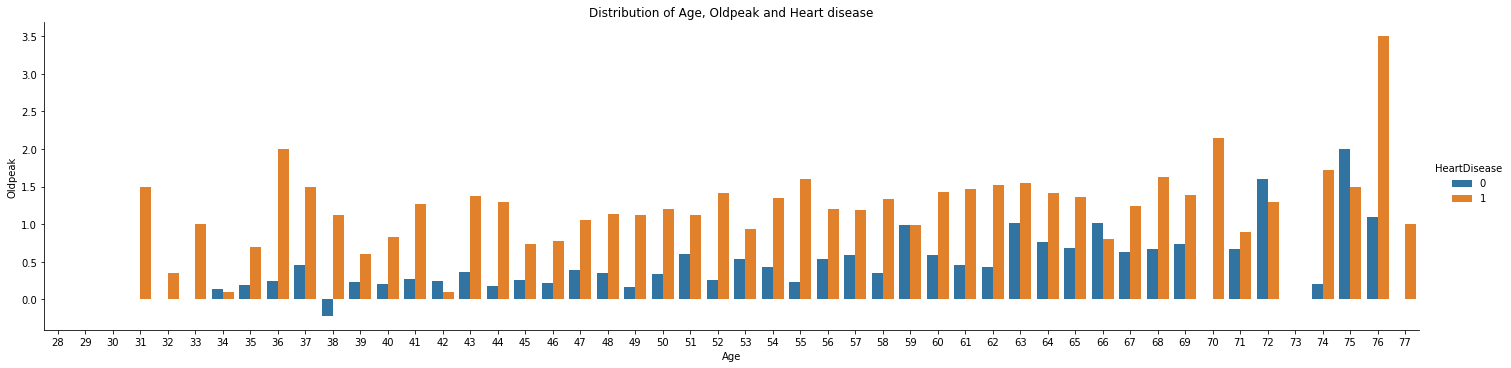

In [342]:
    g = sns.catplot(x= 'Age', y = 'Oldpeak',data=df, aspect=4.0, kind  = 'bar',ci =  None,
                       hue = 'HeartDisease'), 
    plt.title('Distribution of Age, Oldpeak and Heart disease');

This catplot gives us a good distribution of age, oldpeak and whether or not a person had heart disease. We can see that it can start as early as 31 and peaks at age 58. People vulnerable to heart disease are most at risk with oldpeak levels higher than 1 between the ages of 46 and 69. Alternativly this could be due to the avg age of people in the data set( the mean age was 54  and there were quite a few people in their mid 50's within the data set), if you recall there were farily few people older than 70.

This lineplot tells a similar story, it fluctuates up and down at younger ages but steadily rises around age 45. This is most likely due to the number of people within this age range in the data set. However it clearly shows there is an increased risk of heart disease the older a person gets. With a larger data set we would most likely get a clearer and more accurate picture, other wise people would have a near 100% chance of getting heart disease at 72.

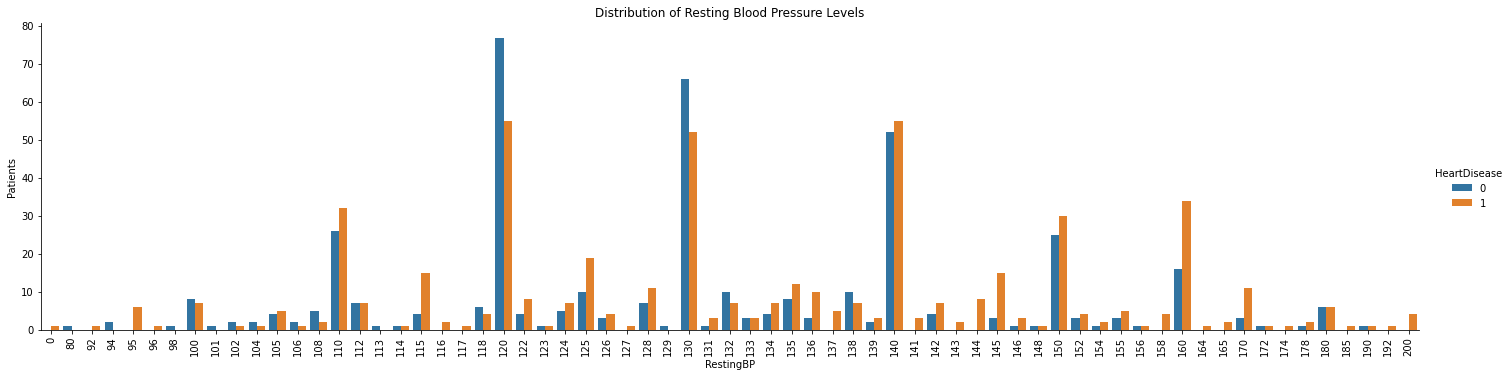

In [343]:
    g = sns.catplot(x= 'RestingBP', data=df, aspect=4.0,kind ='count',
                       hue='HeartDisease');
    g.set_ylabels('Patients');
    g.set_xticklabels(rotation = 90);
    plt.title('Distribution of Resting Blood Pressure Levels');

Here i'm examining which levels of resting blood pressure have the highest distribution of heart disease. Rates of 110, 120, 130, 140, 150, and 160 have the highest occurances, indicating elevated blood pressure, but even at these levels its still split somewhat evenly with 2/6 favoring negative testing results. 

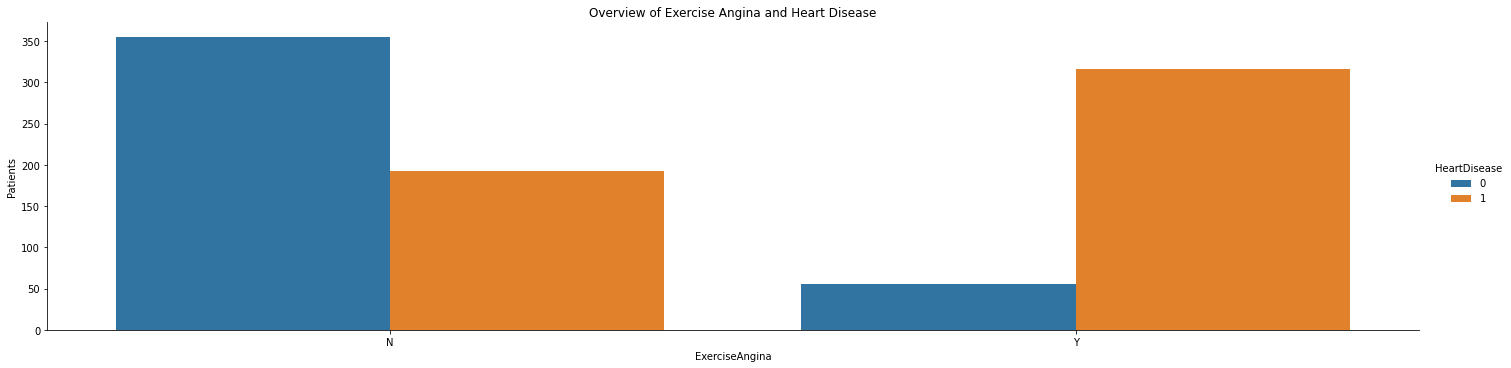

In [344]:
    g = sns.catplot(x= 'ExerciseAngina', data=df, aspect=4.0, kind='count',
                       hue='HeartDisease');
    plt.title('Overview of Exercise Angina and Heart Disease');
    g.set_ylabels('Patients');


This graph indicates that if you did not experience angina while working out, there is about a 36% chance you will still develop heart disease, whereas if you did experience angina while exercising you are about 6-7 times more likely to develop heart disease than not. Is this enough to determine if angina is a valid factor in heart diseae? That's really not for me to say but based off this information, if I were a doctor and my patient was complaining about angina, and if they were older than 45 I would take that very seriously.

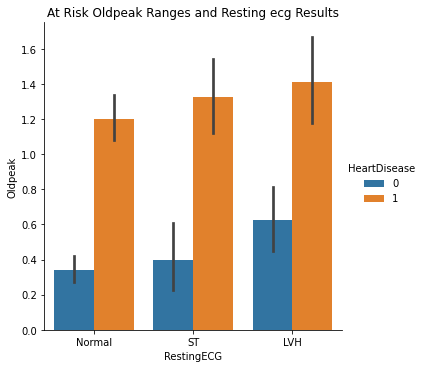

In [345]:
sns.catplot(x = 'RestingECG', y = 'Oldpeak', data = df, hue = 'HeartDisease',kind = 'bar');
plt.title('At Risk Oldpeak Ranges and Resting ecg Results');

This bar graph tells us that the risk of heart disease increases with higher levels of oldpeak and more elevated ECGs. if your oldpeak is below .6 at any resting ecg range, you're much less likely to develop heart disease. This data is consistent with the above tables.


#Machine Learning

##Preprocessing Steps

In [346]:
#Combining the categorical features for heartdisease into one table, maybe my model will find more patterns?
df['Sex,CPT,ECG,EA,& ST_Slope'] = df['Sex']+ ', ' +df['ChestPainType']+ ', ' +df['RestingECG']+ ', ' +df['ExerciseAngina']+ ', ' +df['ST_Slope']
df.drop(['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], axis = 1,inplace = True)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,"Sex,CPT,ECG,EA,& ST_Slope"
0,40,140,289,0,172,0.0,0,"M, ATA, Normal, N, Up"
1,49,160,180,0,156,1.0,1,"F, NAP, Normal, N, Flat"
2,37,130,283,0,98,0.0,0,"M, ATA, ST, N, Up"
3,48,138,214,0,108,1.5,1,"F, ASY, Normal, Y, Flat"
4,54,150,195,0,122,0.0,0,"M, NAP, Normal, N, Up"


In [347]:
#defining function for metric analysis
def eval_regression(true, pred):
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE {mae},\n MSE {mse},\n RMSE: {rmse},\n R^2: {r2} ')

In [348]:
# establishing X features and target y

X = df.drop(columns = 'HeartDisease')
y = df['HeartDisease']

# I'm going to drop resting bp, cholesterol, and max hr as these had either a low correlation or a negative one, essentially being just noise.
df.drop(['RestingBP','Cholesterol','MaxHR'],axis=1,inplace = True)
# as a note dropping these columns had no effect on my metrics

#Instantiating train test split

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42)

In [349]:
#making column selector
num_sel = make_column_selector(dtype_include='number')
cat_sel = make_column_selector(dtype_include='object')

# preprocessing features by scaling and onehot encoding
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

# instantiating column transfer
num_tuple = (scaler,num_sel)
cat_tuple = (ohe,cat_sel)

# creating preprocessor
preprocessor = make_column_transformer(num_tuple,cat_tuple)

In [350]:
#incorporating pca
pca = PCA(n_components=.95)


In [351]:
# allowing the model to explore more features
polyf = PolynomialFeatures(2)

##Decision Tree Regressor

In [352]:
#instantiating decision tree
dtr= DecisionTreeRegressor(random_state=42)
#creating paramater grid for grid search cv
param_grid = {'max_depth':range(1,6)}

In [353]:
#creating and fitting grid search to comb through the best depths for my model
dtr_grid_search = GridSearchCV(dtr,param_grid)
dtr_grid_pipe = make_pipeline(preprocessor,polyf,pca,dtr_grid_search)
dtr_grid_pipe.fit(X_train,y_train)
dtr_grid_search.best_params_

{'max_depth': 2}

In [354]:
#creating new model based off cv
dtbest = dtr_grid_search.best_estimator_
dtbest_pipe = make_pipeline(preprocessor,polyf,pca,dtbest)
dtbest_pipe.fit(X_train,y_train)
dtbest_train_preds = dtbest_pipe.predict(X_train)
dtbest_test_preds = dtbest_pipe.predict(X_test)

In [355]:
#determining metrics
eval_regression(y_train,dtbest_train_preds)
eval_regression(y_test,dtbest_test_preds)

MAE 0.3052961094828795,
 MSE 0.15264805474143972,
 RMSE: 0.3907020024794341,
 R^2: 0.3840780071643818 
MAE 0.3437904851281993,
 MSE 0.18229465671859538,
 RMSE: 0.426959783490899,
 R^2: 0.2545309724479209 


This model is somewhat overfit to the testing data, however the errors it's likely to make are very low and smaller in size.

##Random Forest Regressor

In [356]:
#creating Random Forest model
rf = RandomForestRegressor(n_estimators= 1000,max_features= 2 )
rfparam_grid = {'max_depth':range(1,21),
                'max_features':range(1,5)}
#creating and fitting grid search to comb through the best depths for my model
rf_grid_search = GridSearchCV(rf,rfparam_grid)
rf_grid_pipe = make_pipeline(preprocessor,polyf,pca,rf_grid_search)
rf_grid_pipe.fit(X_train,y_train)
rf_grid_search.best_params_

{'max_depth': 18, 'max_features': 4}

In [357]:
#creating new model based off cv
rfbest = rf_grid_search.best_estimator_
rfbest_pipe = make_pipeline(preprocessor,polyf,pca,rfbest)
rfbest_pipe.fit(X_train,y_train)
rfbest_train_preds = rfbest_pipe.predict(X_train)
rfbest_test_preds = rfbest_pipe.predict(X_test)

In [358]:
#determining metrics
eval_regression(y_train,rfbest_train_preds)
eval_regression(y_test,rfbest_test_preds)

MAE 0.11494225879802532,
 MSE 0.018312024594718906,
 RMSE: 0.13532192946717433,
 R^2: 0.9261125292402941 
MAE 0.3135731161598574,
 MSE 0.12987642285882633,
 RMSE: 0.360383716139931,
 R^2: 0.4688881594594996 


Spiffy metrics, we got good scores on the training data but our r2 score was low on testing. This model is less error prone than the decision tree model and makes smaller errors but is also overfitted to the data.

##Linear Regression

In [359]:
#creating linear regression model
lr = LinearRegression()
lrparam_grid = {'n_jobs':range(1,21)}

In [360]:
#creating and fitting grid search to comb through the best depths for my model
lr_grid_search = GridSearchCV(lr,lrparam_grid)
lr_grid_pipe = make_pipeline(preprocessor,polyf,pca,lr_grid_search)
lr_grid_pipe.fit(X_train,y_train)
lr_grid_search.best_params_

{'n_jobs': 1}

In [361]:
#creating new model based off cv
lrbest = lr_grid_search.best_estimator_
lrbest_pipe = make_pipeline(preprocessor,polyf,pca,lrbest)
lrbest_pipe.fit(X_train,y_train)
lrbest_train_preds = lrbest_pipe.predict(X_train)
lrbest_test_preds = lrbest_pipe.predict(X_test)

In [362]:
#determining metrics
eval_regression(y_train,lrbest_train_preds)
eval_regression(y_test,lrbest_test_preds)

MAE 0.2365092815033439,
 MSE 0.10099866236282308,
 RMSE: 0.3178028671406586,
 R^2: 0.5924789378966506 
MAE 0.26710680780963014,
 MSE 0.12332329165000906,
 RMSE: 0.3511741614213794,
 R^2: 0.49568629187650903 


Not as good as the random forest model but this is less overfit and out perfromed the decsision tree model as well

##KNN

In [363]:
#creating knn model
knn = KNeighborsRegressor()
knnparam_grid = {'n_neighbors':range(1,11),
                 'n_jobs':range(1,5)}

In [364]:
#creating and fitting grid search to comb through the best depths for my model
knn_grid_search = GridSearchCV(knn,knnparam_grid)
knn_grid_pipe = make_pipeline(preprocessor,polyf,pca,knn_grid_search)
knn_grid_pipe.fit(X_train,y_train)
knn_grid_search.best_params_

{'n_jobs': 1, 'n_neighbors': 10}

In [365]:
#creating new model based off cv
knnbest = knn_grid_search.best_estimator_
knnbest_pipe = make_pipeline(preprocessor,polyf,pca,knnbest)
knnbest_pipe.fit(X_train,y_train)
knnbest_train_preds = knnbest_pipe.predict(X_train)
knnbest_test_preds = knnbest_pipe.predict(X_test)

In [366]:
#determining metrics
eval_regression(y_train,knnbest_train_preds)
eval_regression(y_test,knnbest_test_preds)

MAE 0.2661337209302326,
 MSE 0.1235610465116279,
 RMSE: 0.35151251259610644,
 R^2: 0.5014416257501364 
MAE 0.28391304347826085,
 MSE 0.1356086956521739,
 RMSE: 0.3682508596760826,
 R^2: 0.4454468150896723 


Not too bad either. Altough not a particularly high r2 score its not very prone to large errors and is the least overfit of all the models, meaning it would perform better on new data than the others. This model seems the most well balanced

#Conclusions

Of the above models I'de say it's between the random forest and knn. Both had low tendencies for errors and are farily close to each other with their train and test predictions. While all the random forest was not very error prone it is much more overfitted to the data than knn. Knn is the most well balanced allowing it to tackle newer data with fewer issues. While I appreciate the randomness that comes from the forest models they just didnt score as well on the metrics.

If I were to choose which model to put into production i'de choose the knn model as it would prove more adapatable to changing circumstances and new data while maintaining a fair degree of predictive reliability.